In [1]:
#!pip install -v statsmodels
#!pip install -v skforecast

### forecasters/src/fcLib.py

In [2]:
# This script contains a library of ML forecasters developed for the ESTCP project
# The forecasters are designed to copy the sci-kit learn API facilitating implementation

import os
import sys
import math
import numpy as np
import pandas as pd
import warnings
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from scipy.stats import uniform as sp_rand
from scipy.stats import randint

def round_up(n, decimals=0): 
    # Rounds the input to the nearest number of decimals as specified by the user
    multiplier = 10 ** decimals 
    return math.ceil(n * multiplier) / multiplier

class ForecasterBase():
    def fit(self, X=None, y=None):
        '''
        Implements sklearn's fit algorithm to perform the linear regression.
        '''
      
        self.model.fit(X, y)
        
    def predict(self, X=None):
        '''
        Implements sklearn's predict algorithm for the supplied data set.
        Returns the model's predictions for the supplied X values.
        '''
        
        return self.model.predict(X)
    
    def score(self, X, y):
        '''
        Implements sklearn's score slgorithm for the supplied data set.
        Returns the model's r^2 value.
        '''
        return self.model.score(X, y)      

class time_of_week_temperature(BaseEstimator):
    '''
    This class implements the time of week, temperature algorithm
    developed by Johanna Mathieu, Phil Price, Sila Kilccote, and
    Mary Ann Piette. Description: Quantifying Changes in Building
    Electricity Use, with Application to Demand Response, IEEE
    Transactions on Smart Grid, April 2011
    
    The algorithm is a linear regression with specifically
    formatted input data, leveraging the time of week and piecewise
    bins of outdoor air temperature.
    
    The creators of this algorithm recommend creating separate instances
    of the model for 1) Occupied, and 2) Unoccupied times
    
    methods:
    __init__: Initializes the model by creating in instance of 
              LinearRegression, and setting the number of bins
              to use in the outdoor air temperature model.
    format_data: Modifies the input data to implement the outdoor
                 air temperature method in the algorithm. Returns
                 specifically formatted X and y datasets, matching
                 sklearn's API, for use in fitting and testing the
                 model.
    fit: Implements sklearn's fit algorithm.
    predict: Implements sklearn's predict algorithm. Returns the
             predictions for the input X data.
    score: Implements sklearn's score algorithm to return the r^2
           coefficient for the supplied X and y data.
    '''
    
    def __init__(self, **args):
        '''
        Initializes the model by reading the parameters from the args dictionary.
        The required arguments are described in the inputs.
        
        Inputs:
        oat_col: The name of the dataframe column containing ambient air temperature
                 data.
        power_col: The name of the dataframe column containing the building's electric
                   power consumption data.
        '''
        
        self.args = args        
        
    def format_data(self, X, caller):
        '''
        This function pre-processes a data set to provide the right
        inputs for the linear regression process. It 1) Creates the
        bins used in the piecewise linear regression, and 2) Splits
        the data into X and y data sets.
        
        The algorithm must be able to locate the outdoor air temperature
        column to perform the analysis.
        
        inputs:
        X: A dataframe containing the data set to be used in the
              analysis. Must include outdoor air temperature, time of
              week, and power.
        caller: The name of the function calling format_data. There is
                specific logic to execute only when called by .fit().
        temp_col: The name of the column containing the outdoor air
                  temperature.
        '''

        X_formatted = X.copy(deep=True)

        # Make Time of Week column
        X_formatted['Time of Week (hr)'] = X_formatted.index.dayofweek * 24 + X_formatted.index.hour
        self.time_col = 'Time of Week (hr)'
        self.oat_col = [col for col in X_formatted.columns if self.args['oat_col_identifier'] in col][0]
        X_formatted = X_formatted[[self.oat_col, self.time_col]]

        if caller == 'fit':
            
            self.oat_max = X_formatted[self.oat_col].max()
            self.oat_min = X_formatted[self.oat_col].min()
            self.oat_range = self.oat_max - self.oat_min
            self.bin_size = round_up(self.oat_range/self.args['number_bins'], 1)

        for i in range(0, self.args['number_bins']):
            col = self.oat_min + i * self.bin_size
            X_formatted['{}'.format(col)] = np.maximum(0, np.minimum(self.bin_size, X_formatted[self.oat_col] - col)) 
        del X_formatted[self.oat_col]
            
        return X_formatted        
        
    def fit(self, X, y):
        """
        Iteratively creates a linear regression model for each hour of the day and stores
        the coefficients for that model in a dataframe.
        
        Inputs:
        X : The features data set.
        y: The targets data set.
        """

        from sklearn.linear_model import LinearRegression
                    
        X_fit = X.copy(deep = True)
        X_fit = self.format_data(X=X_fit, caller = 'fit')
        y_fit = y[self.args['target_col']]

        empty = []
        self.models = {}
        for hour in range(0, X_fit['Time of Week (hr)'].max()+1):

            X_hr = X_fit.loc[(X_fit['Time of Week (hr)'] == hour)]
            y_hr = y_fit.loc[X_hr.index]

            if len(X_hr.index) == 0:
                empty.append(hour)
                self.models[hour] = None
            elif len(y_hr.index) == 0:
                empty.append(hour)
                self.models[hour] = None
            else:
                model = LinearRegression()
                self.models[hour] = model.fit(X_hr, y_hr)
        if len(empty) > 0:
            print('WANRING: No data for hours {}'.format(empty)) 

    def predict(self, X):
        '''
        Predicts the system response for the given X data. Returns the values
        predicted for the given data set.
        
        Inputs:
        X: The features data set for which predictions are desired.
        
        Outputs:
        Returns the values predicted for the given X data set.
        '''
                    
        result = pd.DataFrame(index = X.index)
        predict_cols = [col for col in X.columns if self.args['oat_col_identifier'] in col]
        X = X[predict_cols]
        
        for col in X.columns:
            temp = pd.DataFrame(index = X.index, columns = [col])
            temp[col] = X[col]

            temp = temp.rename(columns = {col: self.oat_col})
            X_predict = self.format_data(X=temp, caller = 'predict')

            for row in X_predict.index:
                hour = X_predict.loc[row, 'Time of Week (hr)']
                X_temp = pd.DataFrame(columns = X_predict.columns)
                X_temp.loc[row] = X_predict.loc[row]
                try:
                    prediction = self.models[hour].predict(X_temp)
                except Exception as e:
                    print('error: {}'.format(e))
                    prediction = 0
                result.loc[row, col] = prediction

        result = result.fillna(0)
        return(result.values)
    
    def score(self, X, y):
        '''
        Returns the r2 value comparing the predictions for the given X data set to
        the provided y data set.
        
        Inputs:
        X: The features data set.
        y: The corresponding target data set.
        '''
        
        pred = self.predict(X)

        score = r2_score(y, pred)
        
        return score 
todt = {
        'name': 'todt',
        'fun': 'time_of_day_temperature',
        'parameter': {
                      'LR': {
                                          },
                      'oat_col_identifier': 'Tamb_forecast',
                      'target_col': 'Ppv_forecast_1',
                      'number_bins': 6
                     },
        'description': '''scikit-learn LinearRegression model with input data 
                       formatted to create individual regressions for each
                       hour of the day.'''
       }      

class extratreespipeline(ForecasterBase, BaseEstimator):
    '''
    Implements a high-performing pipeline identified by TPOT based on sklearn's
    ExtraTreesRegressor and PolynomialFeatures algorithms. Mimics the scikit-learn
    API.
    
    methods:
    __init__: Initializes the class, loads the sklearn packages, stores the model
              as an attribute to self.
    '''

    def __init__(self, **args):        
        '''
        Initializes the class, loads the sklearn packages, stores the pipeline
        as an attribute to self.
        '''
        
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.ensemble import ExtraTreesRegressor
        from sklearn.pipeline import make_pipeline
        
        args_pf = args['polynomialfeatures']
        args_et = args['extratrees']
        
        self.model = make_pipeline(
                                   PolynomialFeatures(**args_pf),
                                   ExtraTreesRegressor(**args_et)
                                  )   

class randomforestpipeline(ForecasterBase, BaseEstimator):
    '''
    Implements a high-performing pipeline identified by TPOT based on sklearn's
    RandomForestRegressor and PolynomialFeatures algorithms. Mimics the scikit-learn
    API.
    
    methods:
    __init__: Initializes the class, loads the sklearn packages, stores the model
              as an attribute to self.
    '''    
        
    def __init__(self, **args):
        '''
        Initializes the class, loads the sklearn packages, stores the pipeline
        as an attribute to self. The default values match the outputs from a TPOT
        optimization.
        '''
        
        from sklearn.preprocessing import PolynomialFeatures, RobustScaler
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.pipeline import make_pipeline
        
        args_pf = args['polynomialfeatures']
        args_rs = args['robustscaler']
        args_rf = args['randomforest']             
        
        self.model = make_pipeline(
                                   PolynomialFeatures(**args_pf),
                                   RobustScaler(**args_rs),
                                   RandomForestRegressor(**args_rf)
                                  )

class mlpregressor(ForecasterBase, BaseEstimator):
    '''
    Implements scikit-learn's MLP regressor algorithm. Currently uses scikit-learn's 
    default parameters as the default parameters in this implementation.
    
    methods:
    __init__: Initializes the class, loads the sklearn packages, stores the model
              as an attribute to self.
    '''    
        
    def __init__(self, **args):
        '''
        Initializes the class, loads the sklearn packages, stores the model
        as an attribute to self.
        '''
        
        from sklearn.neural_network import MLPRegressor
        from warnings import simplefilter
        from sklearn.exceptions import ConvergenceWarning
        
        simplefilter('ignore', category = ConvergenceWarning)
        
        
        self.model = MLPRegressor(**args)
        self.search_parameters = {
                                  'grid_small': {
                                                 'hidden_layer_sizes': [100, 300, 600],
                                                 'max_iter': [200, 400, 600],
                                                 'momentum': [0.1, 0.5, 0.9]
                                                },
                                  'grid_large': {
                                                 'hidden_layer_sizes': [100, 300, 600],
                                                 'alpha': [0.00005, 0.0001, 0.0002],
                                                 'max_iter': [200, 300, 500, 700],
                                                 'momentum': [0.1, 0.3, 0.5, 0.7, 0.9],
                                                 'learning_rate_init': [0.0001, 0.001, 0.01]
                                                },                     
                                  'randomized': {
                                                 'hidden_layer_sizes': randint(50, 600),
                                                 'alpha': sp_rand(),
                                                 'max_iter': randint(1000, 5000),
                                                 'momentum': sp_rand()
                                                }
                                 }                     
    
class randomforest(ForecasterBase, BaseEstimator):
    '''
    Implements scikit-learn's RandomForestRegressor algorithm. Currently uses scikit-learn's 
    default parameters as the default parameters in this implementation.
    
    methods:
    __init__: Initializes the class, loads the sklearn packages, stores the model
              as an attribute to self.
    '''    
        
    def __init__(self, **args):
        '''
        Initializes the class, loads the sklearn packages, stores the model
        as an attribute to self.
        '''
        
        from sklearn.ensemble import RandomForestRegressor
        
        self.model = RandomForestRegressor(**args)
        self.search_parameters = {
                                  'grid_small': {
                                                 'n_estimators': [50, 200, 600],
                                                 'min_samples_split': [2, 4, 6, 8],
                                                 'max_features': [1, 2, 4, 6, 8]
                                                },
                                  'grid_large': {
                                                 'n_estimators': [50, 100, 200, 300, 400, 500, 600],
                                                 'min_samples_split': [2, 4, 6, 8],
                                                 'min_samples_leaf': [1, 3, 5, 7, 9],
                                                 'max_features': [1, 2, 4, 6, 8],
                                                 'min_weight_fraction_leaf': [0.0, 0.2, 0.4, 0.6, 0.8]                                      
                                                },                     
                                  'randomized': {
                                                 'n_estimators': randint(50, 600),
                                                 'min_samples_split': randint(2, 6),
                                                 'min_samples_leaf': randint(1, 5),
                                                 'max_features': randint(2, 8)
                                                }
                                 }
    
class extratrees(ForecasterBase, BaseEstimator):
    '''
    Implements scikit-learn's ExtraTreesRegressor algorithm. Currently uses scikit-learn's 
    default parameters as the default parameters in this implementation.
    
    methods:
    __init__: Initializes the class, loads the sklearn packages, stores the model
              as an attribute to self.
    '''    
        
    def __init__(self, **args):
        '''
        Initializes the class, loads the sklearn packages, stores the model
        as an attribute to self.
        '''
        
        from sklearn.ensemble import ExtraTreesRegressor
        
        self.model = ExtraTreesRegressor(**args)  
        self.search_parameters = {
                                  'grid_small': {
                                                 'n_estimators': [50, 200, 600],
                                                 'min_samples_split': [2, 4, 6, 8],
                                                 'max_features': [1, 2, 4, 6, 8],
                                                },
                                  'grid_large': {
                                                 'n_estimators': [50, 100, 200, 300, 400, 500, 600],
                                                 'min_samples_split': [2, 4, 6, 8],
                                                 'min_samples_leaf': [1, 3, 5, 7, 9],
                                                 'max_features': [1, 2, 4, 6, 8],
                                                 'min_weight_fraction_leaf': [0.0, 0.2, 0.4, 0.6, 0.8]                                
                                                },                     
                                'randomized': {
                                               'n_estimators': randint(50, 600),
                                               'min_samples_split': randint(2, 6),
                                               'min_samples_leaf': randint(1, 5),
                                               'max_features': randint(2, 8)
                                              }
                               }                                 

class gradientboosting(ForecasterBase, BaseEstimator):
    '''
    Implements scikit-learn's GradientBoostingRegressor algorithm. Currently uses 
    scikit-learn's default parameters as the default parameters in this implementation.
    
    Uses scikit-learn's MultiOutputRegressor to convert a single target forecaster into
    a multiple targer forecaster. Cannot be used on single target datasets.
    
    methods:
    __init__: Initializes the class, loads the sklearn packages, stores the model
              as an attribute to self.
    '''
           
    def __init__(self, **args):
        
        '''
        Initializes the class, loads the sklearn packages, stores the model
        as an attribute to self.
        '''
        
        from sklearn.multioutput import MultiOutputRegressor
        from sklearn.ensemble import GradientBoostingRegressor
        
        # Determine if multi-target or single target
        # Default to multi-target if not specified
        if 'targets' not in args:
            targets = 'multiple'
        else:
            targets = args.pop('targets')
        
        if targets == 'multiple':
            self.model = MultiOutputRegressor(GradientBoostingRegressor(**args['GBR']),
                                              **args['MultiOutputRegressor'])

            self.search_parameters = {
                                      'grid_small': {
                                                     'estimator__n_estimators': [50, 200, 350],
                                                     'estimator__max_depth': [1, 5],
                                                    },
                                      'grid_large': {
                                                     'estimator__n_estimators': [50, 100, 200, 300, 400, 500, 600],
                                                     'estimator__min_samples_split': [2, 4, 6, 8],
                                                     'estimator__min_samples_leaf': [1, 3, 5, 7, 9],
                                                     'estimator__max_depth': [1, 2, 3, 4, 5],
                                                     'estimator__max_features': [1, 2, 4, 6, 8],
                                                     'estimator__min_weight_fraction_leaf': [0.0, 0.2, 0.4, 0.6, 0.8]                                
                                                    },                     
                                    'randomized': {
                                                   'estimator__n_estimators': randint(50, 600),
                                                   'estimator__min_samples_split': randint(2, 6),
                                                   'estimator__min_samples_leaf': randint(1, 5),
                                                   'estimator__max_depth': randint(1, 5),
                                                   'estimator__max_features': randint(2, 8)
                                                  }
                                   }         
        elif targets == 'single':
            self.model = GradientBoostingRegressor(**args['GBR'])
            self.search_parameters = {
                                      'grid_small': {
                                                     'n_estimators': [50, 100, 200, 400, 600],
                                                     'min_samples_split': [2, 4, 6, 8],
                                                     'min_samples_leaf': [1, 3, 5, 7],
                                                     'max_depth': [1, 2, 3],
                                                     'max_features': [1, 2, 4, 6, 8]
                                                    },
                                      'grid_large': {
                                                     'n_estimators': [50, 100, 200, 300, 400, 500, 600],
                                                     'min_samples_split': [2, 4, 6, 8],
                                                     'min_samples_leaf': [1, 3, 5, 7, 9],
                                                     'max_depth': [1, 2, 3, 4, 5],
                                                     'max_features': [1, 2, 4, 6, 8],
                                                     'min_weight_fraction_leaf': [0.0, 0.2, 0.4, 0.6, 0.8]                                
                                                    },                     
                                     'randomized': {
                                                    'n_estimators': randint(50, 600),
                                                    'min_samples_split': randint(2, 6),
                                                    'min_samples_leaf': randint(1, 5),
                                                    'max_depth': randint(1, 5),
                                                    'max_features': randint(2, 8)
                                                   }  
                                      } 
class stats_sarimax(BaseEstimator):
    '''
    An implementation of statsmodels SARIMAX function. Currently uses primarily default
    inputs with order, seasonal_order, and trend being adjusted to yield better results.
    
    Note: The base SARIMAX model is not compatible with numpy 1.24. Downgrading to numpy 1.23
    will resolve the issue.
    
    methods:
    __init__: Initializes the class, loads the sklearn packages, stores the model
              as an attribute to self.
    fit: Fits the model using the provided data.
    predict: Uses the model to predict the values for the input
             X data. Returns the predictions.
    score: Calculates and returns the r^2 value for the supplied data set.   
    
    Some parameters are renamed to match scikit-learn API. For instance, 'endog' in
    statsmodels terminology is y in scikit-learn, and y here. 'exog' is changed to 'X'.
    '''
        
    def __init__(self, order_1, order_2, order_3, seasonal_order_1, seasonal_order_2, seasonal_order_3,
                       seasonal_order_4, trend, full_output, callback, return_params, X_column_categories):
        
        '''
        Reads the parameters and stores them as attributes to self so that they can later be
        referenced and used by the other functions. To match scikit-learn API and provide a
        consistent interface all parameters are set when initializing, and not set when
        calling independent functions.
        '''

        import random
        
        self.search_parameters = {
                                  'grid_small': {
                                                 'order_1': [1, 2, 3],
                                                 'order_2': [0, 1],
                                                 'order_3': [0, 1],
                                                 'seasonal_order_1': [0],
                                                 'seasonal_order_2': [1],
                                                 'seasonal_order_3': [1],
                                                 'seasonal_order_4': [4, 5],
                                                },
                                  'grid_large': {
                                                 'order_1': [1, 2, 3],
                                                 'order_2': [0, 1, 2],
                                                 'order_3': [0, 1, 2],
                                                 'seasonal_order_1': [0],
                                                 'seasonal_order_2': [1],
                                                 'seasonal_order_3': [1, 2],
                                                 'seasonal_order_4': [4, 5],
                                                 'trend': [None, 'n', 'c', 't', 'ct'],
                                               },
                                  'randomized': {
                                                 'order_1': randint(0, 4),
                                                 'order_2': randint(0, 4),
                                                 'order_3': randint(0, 4),
                                                 'seasonal_order_1': randint(0, 12),
                                                 'seasonal_order_2': randint(0, 12),
                                                 'seasonal_order_3': randint(0, 12),
                                                 'seasonal_order_4': randint(0, 12),
                                                 'trend': [None, 'n', 'c', 't', 'ct'],
                                                }
                                  }                      


        self.order_1 = order_1
        self.order_2 = order_2
        self.order_3 = order_3
        self.seasonal_order_1 = seasonal_order_1
        self.seasonal_order_2 = seasonal_order_2
        self.seasonal_order_3 = seasonal_order_3
        self.seasonal_order_4 = seasonal_order_4
        self.trend = trend
        self.full_output = full_output
        self.callback = callback
        self.return_params = return_params
        self.X_column_categories = X_column_categories

    def fit(self, X, y, return_summary=False, debug=False):
        '''
        Calls the SARIMA .fit() function to fit the model to the provided data set,
        given the provided parameters. Stores the parameters in self.res_params.

        Inputs:
        X: The features data set.
        y: The targets data set.
        
        return_summary: .fit() can return a summary of the parameters describing the model if desired.
                        if return_summary == True this function will return that information. If not
                        there will be no output.
        debug: print additonal outputs.
        
        Outputs:
        fit_res.summary (Optional): A summary table describing the model fit parameters. Only returned
                                    if return_summary == True.
        '''        
        
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        import warnings
        from statsmodels.tools.sm_exceptions import ConvergenceWarning
        
        warnings.simplefilter('ignore')

#         cols = []        
#         for category in self.X_column_categories:
#             cols_category = [col for col in X.columns if category in col]
#             if len(cols_category) > 1:
#                 cols.append(cols_category[0])
#             else:
#                 cols.append(cols_category)
#         X = X[cols].values     

        for col in X.columns:
            if X[col].dtype == 'bool':
                X = pd.get_dummies(X, columns=[col], drop_first = True)
        X = X.values        
        
        self.model = SARIMAX(y[y.columns[0]], exog = X, order = (self.order_1, self.order_2, self.order_3), 
                             seasonal_order = (self.seasonal_order_1, self.seasonal_order_2, self.seasonal_order_3, 
                                               self.seasonal_order_4), trend = self.trend)

        fit_res = self.model.fit(full_output = self.full_output, callback = self.callback, 
                                 return_params = self.return_params, disp=int(debug))

        self.res_params = fit_res.params
        
        if return_summary:
            return fit_res.summary()
        
    def predict(self, X):
        '''
        Returns the predicted y values for the provided X data set.
        
        Inputs:
        X: Dataframe of X data for which the model fit is to be tested.
        
        Outputs:
        Returns predicted y values for the provided X data set.
        '''
        
        result = pd.DataFrame(columns = range(int(len(X.columns) / len(self.X_column_categories))))

        for row in X.index:

            X_pred = pd.DataFrame()
            for col in self.columns:
#                 cols_category = [col for col in X.columns if category in col]
                X_pred[cols_category[0]] = X.loc[row, cols_category].T.values

            ix = pd.Series(index = range(0, len(cols_category)), dtype = 'object')
            ix[0] = row
            ix[1:] = ix[0] + pd.to_timedelta(ix.index[1:], unit = 'hours')
            X_pred.index = ix
            
            prediction_horizon = len(X_pred.index)
        
            res = self.model.filter(self.res_params)
            predict = res.forecast(steps=prediction_horizon, exog = X_pred.values).T
            result.loc[row] = predict.values

        return result.values
    
    def score(self, X, y):
        '''
        Calculates the r^2 value of the model given the provided X and y data.
        Predicts the resulting values over the period, compares them to
        the provided y data, calculates and returns the r^2 coefficient.
        
        Inputs:
        X: A data series or dataframe containing exogynous data for the model.
        y: The measured values over the specified period.
        
        Outputs:
        Returns the r^2 value measuring quality of fit for the model over the
               provided data set.
        '''

        import numpy as np
        
        predicted = self.predict(X)
        score = r2_score(y, predicted)
        
        return(score)  

class time_of_day_temperature():
    """
    Implement's Rongxin's regression model. Creates a LinearRegression model driven
    by outdoor air temperature for each hour of the day. Must be able to identify
    the columns containing outdoor air temperature, building power, and hour of the
    day, which are specified in the parameters dictionary.
    
    methods:
    fit: Iteratively fits a linear regression model to the data set for each
         hour of the day. Stores the parameters in a dataframe for later use
         predicting.
    predict: Iteratively predicts the building's power consumption for each
             hour of the day. References the dataframe of parameters stored
             when fitting.
    score: Calculates the r2 value of the model by comparing predictions
           to the provided real y data.
    """
    
    def __init__(self, **args):
        '''
        Initializes the model by reading the parameters from the args dictionary.
        The required arguments are described in the inputs.
        
        Inputs:
        oat_col: The name of the dataframe column containing ambient air temperature
                 data.
        power_col: The name of the dataframe column containing the building's electric
                   power consumption data.
        '''
        
        self.args = args        
        self.intercept = pd.DataFrame()
        self.slope = pd.DataFrame()
        
    def fit(self, X, y):
        """
        Iteratively creates a linear regression model for each hour of the day and stores
        the coefficients for that model in a dataframe.
        
        Inputs:
        X : The features data set.
        y: The targets data set.
        """

        from sklearn.linear_model import LinearRegression
                    
        X = X.copy(deep = True)
        X['hour'] = X.index.hour
        cols = [col for col in X.columns if self.args['oat_col_identifier'] in col]
        cols.append('hour')
        X = X[cols]

        empty = []

        for hour in range(24):
    
            X_hr = X.loc[(X.index.hour == hour)]
            y_hr = y.loc[y.index.hour == hour]

            for ix in range(X_hr.shape[1]):
                if X_hr.columns[ix] == 'hour':
                    continue
                    
                X_temp = X_hr[[X_hr.columns[ix], 'hour']]
                y_temp = y_hr[[y_hr.columns[ix]]]
                
                if len(X_hr.index) == 0:
                    empty.append(hour)
                    self.intercept.loc[hour] = 0
                    self.slope.loc[hour] = 0
                elif len(y_hr.index) == 0:
                    empty.append(hour)
                    self.intercept.loc[hour] = 0
                    self.slope.loc[hour] = 0
                else:
                    model = LinearRegression()
                    model.fit(X_temp, y_temp)
                    self.intercept.loc[hour, ix] = model.intercept_[0]
                    self.slope.loc[hour, ix] = model.coef_[0][0]
        if len(empty) > 0:
            print('WANRING: No data for hours {}'.format(empty)) 

    def predict(self, X):
        '''
        Predicts the system response for the given X data. Returns the values
        predicted for the given data set.
        
        Inputs:
        X: The features data set for which predictions are desired.
        
        Outputs:
        Returns the values predicted for the given X data set.
        '''

        result = pd.DataFrame(index = X.index)
                    
        X = X.copy(deep = True)
        X['hour'] = X.index.hour
        cols = [col for col in X.columns if self.args['oat_col_identifier'] in col]
        cols.append('hour')
        X = X[cols]

        result = pd.DataFrame(index = X.index)
        for row in X.index:
    
            hour = row.hour
    
            for col in range(X.shape[1]):
                if X.columns[col] == 'hour':
                    continue
            
                b = self.intercept.loc[hour, col]
                m = self.slope.loc[hour, col]
                prediction = b + m * X.loc[row, X.columns[col]]
                result.loc[row, col] = prediction

        return(result.values)
    
    def score(self, X, y):
        '''
        Returns the r2 value comparing the predictions for the given X data set to
        the provided y data set.
        
        Inputs:
        X: The features data set.
        y: The corresponding target data set.
        '''
        
        pred = self.predict(X)
        score = r2_score(y, pred)
        
        return score

class forecasters():
    '''
    This class provides storage and utility functions for the available forecasters.
    '''
    
    def __init__(self, forecaster_list):
        '''
        Initializes the class to contain data on the forecasters. Requires two inputs and stores
        the data as attributes
        
        Inputs:
        forecaster_list: A list of data about each forecaster. Each entry in the list must
                         be a dictionary following the structure used in this library. See the code
                         for more information.
        models: A dictionary of the available forecasters with their associated parameters. The forecasters
                are typically initialized using the parameters specified in forecaster_list.
        '''
        
        import random
        from scipy.stats import uniform as sp_rand
        from scipy.stats import randint
        
        self.forecasters = forecaster_list
    
    def format_output(self, forecaster, search):
        '''
        Extracts the results from the hyperparameter tuning process for each forecaster. Identifies and
        returns the score and parameters of the best performing algorithm. Amends the parameter structure
        of forecasters as required.
        
        Inputs:
        forecaster: The name of the forecaster, expressed using the 'fun' parameter from forecaster_list.
        search: The scikit-learn search object storing the score and parameters for each iteration.
        
        Outputs:
        score: The calculated score of the best performing hyperparameter set for that forecaster.
        parameters: The parameters of the best performing iteration, formatted as necessary.
        '''
        
        import pandas as pd

        score = search.best_score_
        score = np.sqrt(-score)
        parameters = search.best_params_

        if forecaster['fun'] == 'gradientboosting':
            temp = {}
            for key in parameters.keys():
                new_key = key.replace('estimator__', '')
                temp[new_key] = parameters[key]
            parameters = {
                          'MultiOutputRegressor': {},
                          'GBR': temp
                         }
        elif forecaster['fun'] == 'stats_sarimax':
            parameters['full_output'] = forecaster['parameter']['full_output']
            parameters['callback'] = forecaster['parameter']['callback']
            parameters['return_params'] = forecaster['parameter']['return_params']
            parameters['trend'] = forecaster['parameter']['trend']
            parameters['X_column_categories'] = forecaster['parameter']['X_column_categories']

        return score, parameters
    
    def tune_hyperparameters(self, X, y, method='grid_small', cv=None, n_forecasters=5,
                             n_jobs=None, n_iter=100, random_state=42):
        '''
        Calls the scikit-learn GridSearchCV or RandomizedSearchCV function to tune the hyperparameters of
        the forecasters in the library. This algorithm will only perform optimization on forecasters that
        include the 'search_parameters' attribute. Stores a list of tuned_forecasters un the class
        enabling use of the tuned forecasters in the future.
        
        Inputs:
        X: The X data set to be used in hyperparameter tuning.
        y: The y data set to be used in hyperparameter tuning.
        method: The search method to be used. Options are 'grid_small', 'grid_large' and 'randomized'.
        cv (optional): The number of folds to use when performing cross-validation.
        n_forecsters (optional): The number of tunable forecasters to include when returning the best
                      performing models.
        n_jobs (optional): The number of cores to use when performing the hyperparameter tuning.
        n_iter (optional): The number of iterations to use when performing randomized search.
        random_state (optional): The random state to use when perfoming randomized search.
        '''
        
        from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
        import sys
    
        result = pd.DataFrame(columns = ['score', 'forecaster', 'parameters'])
    
        i = 0
        
        self.tuned_forecasters = []
        
        completed = []
        
        for forecaster in self.forecasters:
            
            model = getattr(sys.modules[__name__], forecaster['fun'])(**forecaster['parameter'])

            if not hasattr(model, 'search_parameters'):
                continue
                
            elif forecaster['fun'] in completed:
                continue

            model_params = model.search_parameters[method]                
                
            if forecaster['fun'] != 'stats_sarimax':
                model = model.model
                
            scoring = 'neg_mean_squared_error'

            if 'grid' in method:
                search = GridSearchCV(model, model_params, cv = cv, scoring = scoring, n_jobs = n_jobs, 
                                      return_train_score = True)
                search.fit(X, y)
                    
            elif method == 'randomized':
                search = RandomizedSearchCV(model, model_params, n_iter = n_iter, cv = cv, scoring = scoring, 
                                            n_jobs = n_jobs, random_state = random_state)
                search.fit(X, y)
            else:
                sys.exit('ERROR: method {} not supported.')

            score, parameters = self.format_output(forecaster, search)

            result.loc[i, 'score'] = score
            result.loc[i, 'forecaster'] = forecaster['fun']
            result.loc[i, 'parameters'] = [parameters]
            
            i += 1

            completed.append(forecaster['fun'])
    
        result['score'] = pd.to_numeric(result['score'])
        result = result.nsmallest(n_forecasters, 'score')
        
        for row in result.index:
            forecaster = result.loc[row, 'forecaster']
            parameters = result.loc[row, 'parameters'][0]   
            temp = {
                    'name': '{}_autotuned'.format(forecaster),
                    'fun': forecaster,
                    'parameter': parameters,
                    'description': '{} with hyperparameters tuned using self.tune_forecasters()'.format(forecaster)
                   }
            self.tuned_forecasters.append(temp)
        
# The following dictionaries contain information about and default parameters for the
# forecasters in this library
# 'name' states the name of the forecaster
# 'fun' provides the name of the function
# 'parameter' provides the parameters for the forecaster. Depending on the needs of the 
# forecaster they are often nested dictionaries. The values provided in the dictionaries
# are typically the default values for the forecaster tools. In some specific cases, such
# as time of week temperature they are the values needed to use the test data set
# 'requires_forecast' states whether or not a weather forecast is mandatory for
# using the forecaster
# 'description' provides a short description of the forecaster and how it functions
    
towt = {
        'name': 'towt',
        'fun': 'time_of_week_temperature',
        'parameter': {
                      'LR': {
                                          },
                      'number_bins': 6,
                      'oat_col_identifier': 'Tamb_forecast',
                      'target_col': 'Ppv_forecast_1'
                     },
        'requires_forecast': False,
        'description': '''scikit-learn LinearRegression model with input data 
                       formatted to provide 1) outdoor temperature split into bins
                       and 2) the time of the week.'''
       }
    
extra_trees_pipeline = {
                        'name': 'extra_trees_pipeline',
                        'fun': 'extratreespipeline',
                        'parameter': {
                                      'polynomialfeatures': {
                                                             'include_bias': False
                                                            },
                                      'extratrees': {
                                                     'min_samples_split': 6,
                                                     'min_samples_leaf': 2,
                                                     'max_features': 0.4
                                                    }
                                     },
                        'requires_forecast': True,
                        'description': '''scikit-learn ExtraTreesRegressor pipeline as recommended by TPOT. 
                                       Pre-processes the data with scikit-learn's PolynomialFeatures. 
                                       Default values as recommended by TPOT.'''
                       }
random_forest_pipeline = {
                          'name': 'random_forest_pipeline',
                          'fun': 'randomforestpipeline',
                          'parameter': {
                                        'polynomialfeatures': {
                                                               'interaction_only': False
                                                              },
                                        'robustscaler': {
                                                        },
                                        'randomforest': {
                                                         'min_samples_split': 13,
                                                         'min_samples_leaf': 5,
                                                         'max_features': 0.25,
                                                         'bootstrap': False
                                                        }
                                       },
                         'requires_forecast': True,
                         'description': '''scikit-learn RandomForestRegressor pipeline as recommended by TPOT.
                                        Uses scikit-learn's PolynomialFeatures and robustscaler to pre-process
                                        the data. Default parameters are as recommended by TPOT'''
                         }
multi_layer_perceptron = {
                          'name': 'multi_layer_perceptron',
                          'fun': 'mlpregressor',
                          'parameter': {
                                       },
                          'requires_forecast': True,
                          'description': '''scikit-learn MLPRegressor model with default parameters'''
                         }
tuned_mlp = {
             'name': 'tuned_mlp',
             'fun': 'mlpregressor',
             'parameter': {
                           'hidden_layer_sizes': 500,
                           'alpha': 0.005050,
                           'max_iter': 5000,
                           'momentum': 0.1
                          },
             'requires_forecast': True,
             'description': '''scikit-learn MLPRegressor model parameters tuned to optimize results on 
                            several meters (average score) in Camp Parks, 2020 data set'''
            }

tuned_Total_mlp = {
                   'name': 'tuned_Total_mlp',
                   'fun': 'mlpregressor',
                   'parameter': {
                                 'hidden_layer_sizes': 500,
                                 'alpha': 0.01,
                                 'max_iter': 5000,
                                },
                   'requires_forecast': True,
                   'description': '''scikit-learn MLPRegressor model parameters tuned to optimize results on 
                                  Total Load in Camp Parks, 2020 data set'''
                  }

tuned_Fast_mlp = {
                  'name': 'tuned_Fast_mlp',
                  'fun': 'mlpregressor',
                  'parameter': {
                                'hidden_layer_sizes': 300,
                                'alpha': 0.00505,
                                'max_iter': 5000,
                                'shuffle': True, 
                                'random_state': None, 
                                'tol': 0.0001, 
                                'momentum': 0.5
                               },
                  'requires_forecast': True,
                  'description': '''scikit-learn MLPRegressor model parameters tuned to yield high performance 
                                 Total Load in Camp Parks, 2020 data set with fast simulation times. This is
                                 the fastest parameter set with r2 score > (tuned mlp - 0.02)'''
                 }

random_forest = {
                 'name': 'random_forest',
                 'fun': 'randomforest',
                 'parameter': {
                               },
                 'requires_forecast': True,
                 'description': '''scikit-learn RandomForestRegressor model with default parameters'''
                }

extra_trees = {
               'name': 'extra_trees',
               'fun': 'extratrees',
               'parameter': {
                             },
               'requires_forecast': True,
               'description': '''scikit-learn ExtraTreesRegressor model with default parameters'''
              }

gradient_boosting = {
                     'name': 'gradient_boosting',
                     'fun': 'gradientboosting',
                     'parameter': {
                                   'targets': 'multiple',
                                   'GBR': {
                                           'max_depth': 3
                                          },
                                   'MultiOutputRegressor': {
                                                            },
                                  },
                     'requires_forecast': True,
                     'description': '''scikit-learn GradientBoostingRegressor model with
                                    default parameters. Uses scikit-learn MultiOutputRegressor
                                    to enable predicting multi-target problems. Cannot predict
                                    single target problems.'''
                    }

sarimax = {
           'name': 'sarimax',
           'fun': 'stats_sarimax',
           'parameter': {
                         'order_1': 2,
                         'order_2': 0,
                         'order_3': 0,
                         'seasonal_order_1': 0,
                         'seasonal_order_2': 1,
                         'seasonal_order_3': 1,
                         'seasonal_order_4': 4,
                         'trend': 'n',
                         'full_output': 1,
                         'callback': None,
                         'return_params': False,
                         'X_column_categories': ['Tamb_forecast', 'clear_sky_forecast', 'cloud_cover_forecast',
                                                'Ppv_dminus1_forecast']
                        },
           'requires_forecast': False,
           'description': '''statsmodels SARIMAX seasonal forecasting algorithm using default parameters.'''
          }
    
todt = {
        'name': 'todt',
        'fun': 'time_of_day_temperature',
        'parameter': {
                      'LR': {
                                          },
                      'oat_col_identifier': 'Tamb_forecast',
                     },
        'requires_forecast': False,
        'description': '''scikit-learn LinearRegression model with input data 
                       formatted to create individual regressions for each
                       hour of the day.'''
       }


forecaster_list = [extra_trees_pipeline, random_forest_pipeline, multi_layer_perceptron, tuned_mlp, 
                   tuned_Total_mlp, tuned_Fast_mlp, random_forest, extra_trees, gradient_boosting, todt, towt, sarimax]

if __name__ == '__main__':
    
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from sklearn.exceptions import ConvergenceWarning
    import warnings
    import pandas as pd
    import ast
    import numpy as np
    import os
    import time
    import math   
    import inspect    
    
    # Read in example data set
    cwd = os.getcwd()
    path_data = os.path.join(cwd, '..', 'resources', 'data', 'forecaster_example_data.csv')
    df = pd.read_csv(path_data, index_col = [0])
    df.index = pd.to_datetime(df.index)       

    # Split data set into X and y data sets
    X = df[[col for col in df.columns if not 'Ppv_forecast' in col]]
    y = df[[col for col in df.columns if 'Ppv_forecast' in col]]        
    
    # Create a dataframe to store the score when compared against test data and the computation time of each
    # forecaster

    forecaster_names = [forecaster['name'] for forecaster in forecaster_list]
    forecaster_names.remove('towt')
    
    forecaster_functions = [forecaster['fun'] for forecaster in forecaster_list]    

    result = pd.DataFrame(0, index = forecaster_names, 
                          columns = ['Test Score', 'RMSE', 'Computation Time (s)'])
    
    # Split X and y into train and test data sets. Set random_state to ensure repeatability
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42)

    # Many forecasters use stochastic noise in their process and yield a slightly different score each time. 
    # The test code performs x iterations and averages the test score and computation time across all iterations

    iterations = 10
    
    # For each iteration as specified above
    for i in range(iterations):
        
        # For each forecaster
        for forecaster in forecaster_list:
            fc_name = forecaster['name']
            if fc_name == 'towt':
                continue

            model = getattr(sys.modules[__name__], forecaster['fun'])(**forecaster['parameter'])

            start = time.time()

            model.fit(X_train, y_train)

            result.loc[fc_name, 'Test Score'] += model.score(X_test, y_test)
            predict = model.predict(X_test)
            result.loc[fc_name, 'RMSE'] += np.sqrt(mean_squared_error(y_test, predict))

            # Calculate the computation time of the forecasterin pred
            end = time.time()  
            result.loc[fc_name, 'Computation Time (s)'] += end-start

        print('Completed iteration {}'.format(i + 1))
            
    # Tabulate the average of the results for each forecaster
    for fc_name in forecaster_names:
    
        result.loc[fc_name, 'Test Score'] = result.loc[fc_name, 'Test Score']/iterations
        result.loc[fc_name, 'Computation Time (s)'] = result.loc[fc_name, 'Computation Time (s)']/iterations
        result.loc[fc_name, 'RMSE'] = result.loc[fc_name, 'RMSE'] / iterations
    
    # Print results
    print('Average score and computation time metrics over {} iterations'.format(iterations))
    
display(result)

C:\Users\Peter\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Average score and computation time metrics over 10 iterations


,Test Score,RMSE,Computation Time (s)
extra_trees_pipeline,0.951927,198.092684,10.248848
random_forest_pipeline,0.938839,223.166037,27.950360
multi_layer_perceptron,0.927559,242.840052,0.367770
tuned_mlp,0.942040,217.415319,3.923704
tuned_Total_mlp,0.942594,216.373688,3.574721
tuned_Fast_mlp,0.941200,219.015048,3.150327
random_forest,0.952643,196.379781,3.042451
extra_trees,0.951672,198.570347,1.203242
gradient_boosting,0.952143,197.662115,21.473453
todt,0.898098,288.079003,2.443330


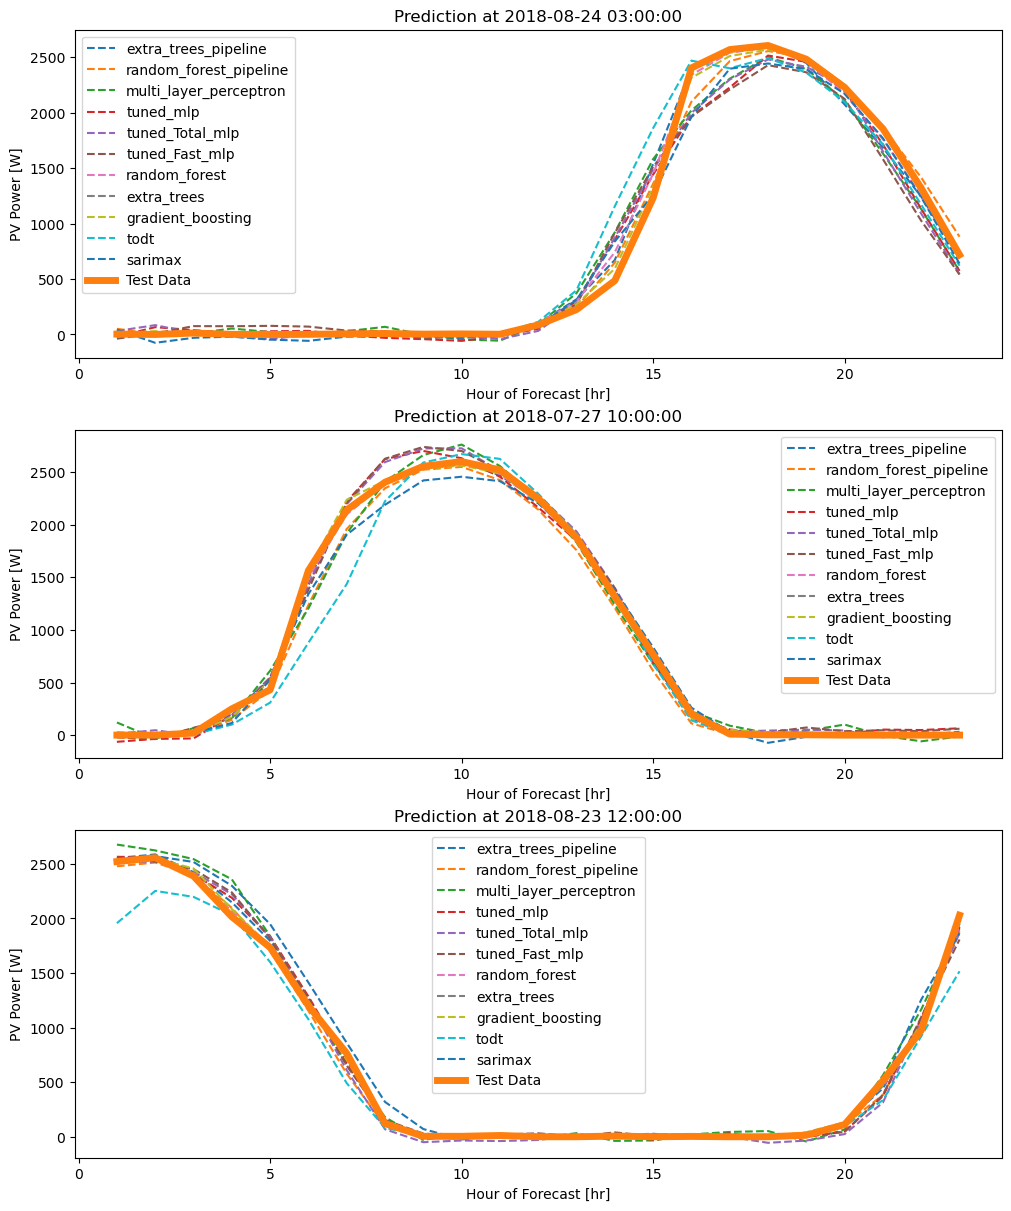

In [3]:
# Create plots comparing the performance of the forecasters at 3 timestamps in the data set

import matplotlib.pyplot as plt

# Specify needed inputs
x = range(1, 24)

index_percents = [0.1, 0.5, 0.9]

# Create the plot figure
number_plots = len(index_percents)
fig, axs = plt.subplots(number_plots, 1, figsize = (10, number_plots * 4), constrained_layout=True)
datetimes = []
    
color = 0
for forecaster in forecaster_list:
    fc_name = forecaster['name']
    if fc_name == 'towt':
        continue

    model = getattr(sys.modules[__name__], forecaster['fun'])(**forecaster['parameter'])


    model.fit(X_train, y_train)
    
    for i in index_percents:
        row = index_percents.index(i)
        index = int(i * len(X_test.index))
        
        forecast = X.iloc[index:index+1]

        predict = model.predict(forecast)

        axs[row].plot(x, predict[0],
                      label = fc_name, linestyle = 'dashed')
    color += 1
        
for i in index_percents:
    row = index_percents.index(i)
    index = int(i * len(X_test.index))    
    
    axs[row].set(xlabel = ('Hour of Forecast [hr]'), ylabel = 'PV Power [W]',
                 title = 'Prediction at {}'.format(str(y_test.index[index])))
    y_real = y.iloc[index:index+1].values[0]
    axs[row].plot(x, y_real, label = 'Test Data', linewidth = 5)    
    axs[row].legend()

plt.show()

In [4]:
tuned = forecasters(forecaster_list)
tuned.tune_hyperparameters(X, y, method = 'grid_small', n_jobs = 3)
tuned.tuned_forecasters

[{'name': 'randomforest_autotuned',
  'fun': 'randomforest',
  'parameter': {'max_features': 8,
   'min_samples_split': 2,
   'n_estimators': 200},
  'description': 'randomforest with hyperparameters tuned using self.tune_forecasters()'},
 {'name': 'extratrees_autotuned',
  'fun': 'extratrees',
  'parameter': {'max_features': 8,
   'min_samples_split': 2,
   'n_estimators': 200},
  'description': 'extratrees with hyperparameters tuned using self.tune_forecasters()'},
 {'name': 'mlpregressor_autotuned',
  'fun': 'mlpregressor',
  'parameter': {'hidden_layer_sizes': 600, 'max_iter': 200, 'momentum': 0.1},
  'description': 'mlpregressor with hyperparameters tuned using self.tune_forecasters()'},
 {'name': 'gradientboosting_autotuned',
  'fun': 'gradientboosting',
  'parameter': {'MultiOutputRegressor': {},
   'GBR': {'max_depth': 5, 'n_estimators': 50}},
  'description': 'gradientboosting with hyperparameters tuned using self.tune_forecasters()'},
 {'name': 'stats_sarimax_autotuned',
  'f